In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-12-01 15:22:21.905155: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-01 15:22:21.905191: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  1897k      0  0:07:04  0:07:04 --:--:-- 1843k:01:08  749k


In [2]:
!unzip -q kagglecatsanddogs_5340.zip

In [2]:
!ls
!ls PetImages

 01-Image_Classification_from_Scratch.ipynb   model.png        save_at_1.keras
 CDLA-Permissive-2.0.pdf		      PetImages
 kagglecatsanddogs_5340.zip		     'readme[1].txt'
Cat  Dog


## Filter out corrupted images

In [3]:
import os

num_skipped = 0
for folder_name in ('Cat', 'Dog'):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
            
        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)
            
print("Deleted %d images" % num_skipped)

Deleted 0 images


## Generate Dataset

In [4]:
image_size = (180, 180)
batch_size = 128

train_ds = tf.keras.preprocessing.image_dataset_from_directory("PetImages",
                                                                      validation_split=0.2,
                                                                      subset="training",
                                                                      seed=1337,
                                                                      image_size=image_size,
                                                                      batch_size=batch_size,
                                                                      )

val_ds = tf.keras.preprocessing.image_dataset_from_directory("PetImages",
                                                                      validation_split=0.2,
                                                                      subset="validation",
                                                                      seed=1337,
                                                                      image_size=image_size,
                                                                      batch_size=batch_size,
                                                                      )

Found 21876 files belonging to 2 classes.
Using 17501 files for training.


2022-12-01 15:22:33.931450: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-01 15:22:33.931467: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-01 15:22:33.931482: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nsl54): /proc/driver/nvidia/version does not exist
2022-12-01 15:22:33.932224: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 21876 files belonging to 2 classes.
Using 4375 files for validation.


## Visualization

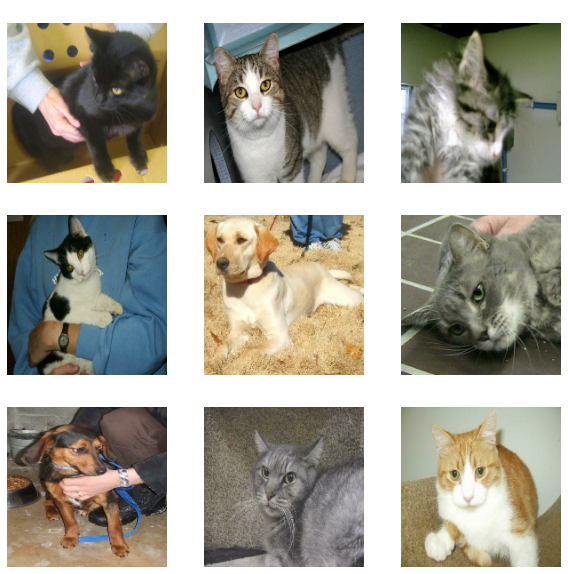

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]), color="white")
        plt.axis("off")

## Using Image Data Augmentation

it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [6]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

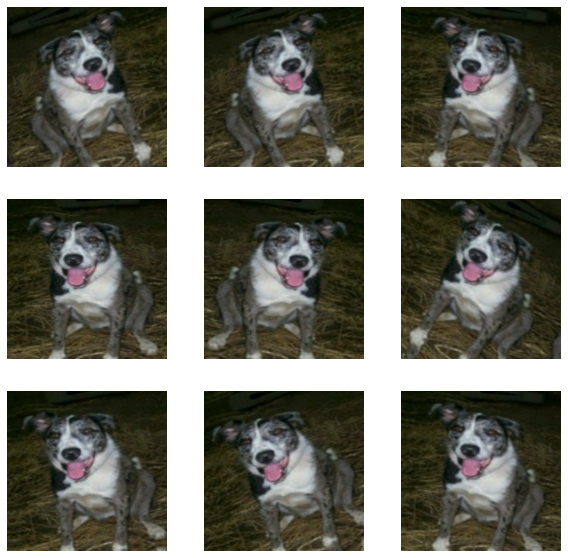

In [7]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range (9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Standardizing the Data

We will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.

## Two options to preprocess the data

### Option 1: Make it part of the model

With this option, data augmentation will happen on device, synchronously with the rest of the model execution, meaning that it will benefit from GPU acceleration.

Data augmentation is inactive at test time, so the input samples will only be augmented during `fit()`, not when calling `evaluate()` or `predict()`.

For training on GPU, this may be a good option.

### Option 2: apply it to the dataset

With this option, data augmentation will happen on CPU, asynchronously, and will be buffered before going into the model.

For training on CPU, this is the better option, since it makes data augmentation asynchronous and non-blocking.

#### We'll go with the second option

## Configure theDataset for Performance


In [8]:
train_ds = train_ds.map(lambda img, label: (data_augmentation(img), label),
                       num_parallel_calls=tf.data.AUTOTUNE,
                       )

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Build model

- We start the model with the `data_augmentation` preprocessor, followed by a `Rescaling` layer
- We include a `Dropout` layer befor the final classification layer

In [9]:
def make_model(input_shape, num_classes):
    
    inputs = keras.Input(shape=input_shape)
    
    x = layers.Rescaling(1.0/255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    previous_block_activation = x
    
    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        
        
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        
        x = layers.add([x, residual])
        previous_block_activation = x
        
        
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
        
    else:
        activation = "softmax"
        units = num_classes
        
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

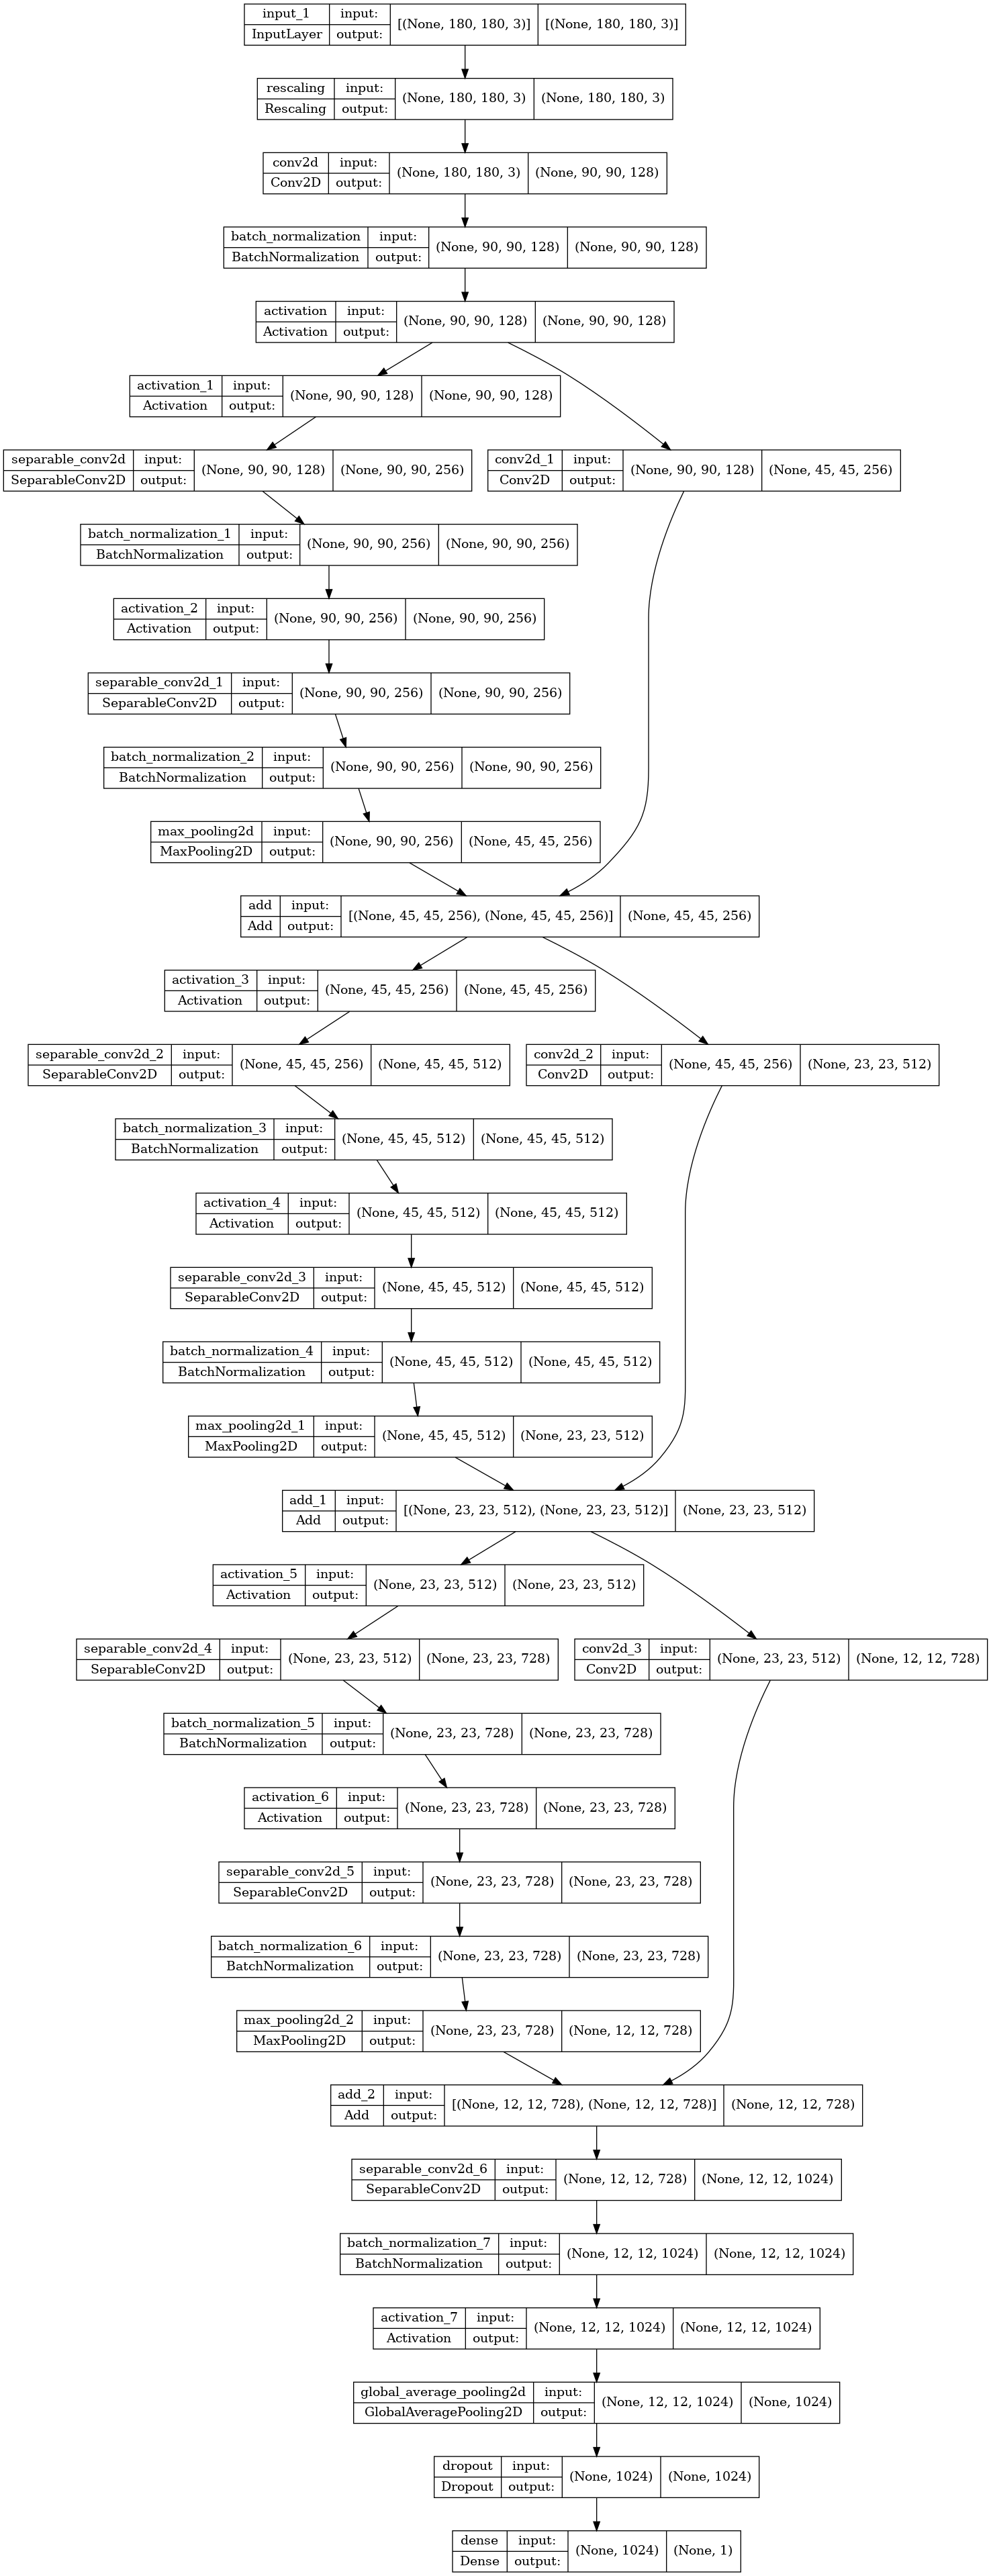

In [10]:
model = make_model(input_shape=image_size+(3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

## Train

In [ ]:
epochs = 25


callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    
]


model.compile(optimizer=keras.optimizers.Adam(1e-3),
             loss="binary_crossentropy",
             metrics=["accuracy"],
             )

model.fit(train_ds,
         epochs=epochs,
         callbacks=callbacks,
         validation_data=val_ds,
         )

Epoch 1/25


2022-12-01 15:22:54.159747: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1061683200 exceeds 10% of free system memory.
2022-12-01 15:22:54.296575: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1061683200 exceeds 10% of free system memory.
2022-12-01 15:22:54.693715: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1061683200 exceeds 10% of free system memory.
2022-12-01 15:22:54.832882: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1061683200 exceeds 10% of free system memory.
2022-12-01 15:22:55.067346: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1061683200 exceeds 10% of free system memory.
